<a href="https://colab.research.google.com/github/ansonkwokth/TableTennisPrediction/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ansonkwokth/TableTennisPrediction.git
%cd TableTennisPrediction

Cloning into 'TableTennisPrediction'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 229 (delta 45), reused 15 (delta 15), pack-reused 161 (from 1)
Receiving objects: 100% (229/229), 1.99 MiB | 6.18 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/TableTennisPrediction


In [2]:

import pandas as pd
from utils import data_loader as dl

import numpy as np
from model.Elo import Elo
from model.ModifiedElo import ModifiedElo
from model.ensemble import BaggingRatingSystem

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import copy
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

# Data

In [3]:
# GAME = 'TTStar'
# GAME = 'TTCup'
# GAME = 'SetkaCup'
GAME = 'SetkaCupWomen'
# GAME = 'LigaPro'


In [6]:
match GAME:
    case 'TTStar':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'TTCup':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'SetkaCup':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'SetkaCupWomen':
        years = [2020, 2021, 2022, 2023, 2024]
    case 'LigaPro':
        years = [2022, 2023, 2024]
    case _:
        raise ValueError("Invalid game selected.")


text_data_game = dl.load_game_data(GAME, years, '../')
text_data = {
    year: text_data_game[year] for year in years
}
df = dl.create_game_dfs(GAME, years, text_data)

Loading ..//SetkaCupWomen2020.txt
Loading ..//SetkaCupWomen2021.txt
Loading ..//SetkaCupWomen2022.txt
Loading ..//SetkaCupWomen2023.txt
Loading ..//SetkaCupWomen2024.txt


In [7]:
# Generate ID indices for each pair of rows in the DataFrame
idx_lt = [i for i in range(len(df) // 2) for _ in range(2)]
df['ID'] = idx_lt  # Assign to the 'ID' column

# Reset the DataFrame index to ensure it's sequential
df.reset_index(drop=True, inplace=True)

# Get unique players and store them in player_lt
player_lt = df['Player'].unique()



In [8]:
year_val = years[-2]
year_test = years[-1]

df_train = df.loc[pd.DatetimeIndex(df['Date']).year < year_val]
df_val = df.loc[pd.DatetimeIndex(df['Date']).year == year_val]
df_test = df.loc[pd.DatetimeIndex(df['Date']).year == year_test]

In [9]:
def format_to_array(df: pd.DataFrame) -> np.ndarray:

    # info_col = ['ID', 'Round', 'Datetime', 'Game', 'Date', 'Time']
    info_col = ['Round', 'Datetime', 'Game', 'Date', 'Time']
    col = [item for item in df.columns if item not in info_col]

    df[[c for c in col if "Set" in c]] = df[[c for c in col if "Set" in c]].astype(float)
    X = df[col].values.reshape(-1, 2, len(col))
    return X

In [10]:
X_train = format_to_array(df_train)
X_val = format_to_array(df_val)
X_test = format_to_array(df_test)

In [11]:
X_all = format_to_array(df)

# Train and Evaluate

In [12]:
# traditional Elo
modelElo = Elo()
# modified Elo
modelMElo = ModifiedElo()
modelMElo0p1 = ModifiedElo(base_param=(0, 0.1))

# traing model with only training set
modelElo.fit(X_train)
modelMElo.fit(X_train)
modelMElo0p1.fit(X_train)


Training model: 100%|██████████| 26120/26120 [00:01<00:00, 18562.19it/s]


In [13]:
# ensembleElo = BaggingRatingSystem(estimator=Elo(), n_models=10, sample_ratio=0.5)
# ensembleElo.fit(X_train)

In [14]:
# ensembleMElo = BaggingRatingSystem(estimator=ModifiedElo(), n_models=10, sample_ratio=0.5)
# ensembleMElo.fit(X_train)

In [15]:
def evaluate(model, dataset):
    print(f"Evaluate model: {repr(model)}")
    _model = copy.deepcopy(model)
    _model.verbose = False
    correct = 0
    n_matches = 0

    history = []
    predictions = []
    for matchi in tqdm(dataset, desc="Evaluating matches"):
        matchi = matchi.T
        player1, player2 = matchi[1]

        found_p1, found_p2, p = _model.predict_game(player1, player2)
        if not (found_p1 and found_p2): continue
        if p == 0.5: continue
        whowillwin = 0 if p > 0.5 else 1

        win1 = sum(matchi[2:, 0]>matchi[2:, 1])
        win2 = sum(matchi[2:, 0]<matchi[2:, 1])
        whowon = 0 if win1 > win2 else 1

        history.append(win1/(win1 + win2))
        predictions.append(p)

        n_matches += 1
        if (whowon == whowillwin): correct += 1

    acc = correct / n_matches
    print(f'\n === Accuracy: {acc} === \n\n')
    return acc, np.array(history), np.array(predictions)



In [16]:
# evaluate the model with the training set
evaluate(modelElo, X_train);
evaluate(modelMElo, X_train);
evaluate(modelMElo0p1, X_train);
# evaluate(ensembleElo, X_train);
# evaluate(ensembleMElo, X_train);


Evaluate model: Elo(learning_rate=32, base_rate=1000, verbose=False)


Evaluating matches: 100%|██████████| 26120/26120 [00:00<00:00, 33881.22it/s]



 === Accuracy: 0.5256891271056662 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 26120/26120 [00:00<00:00, 26400.91it/s]



 === Accuracy: 0.6153905053598775 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 0.1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 26120/26120 [00:00<00:00, 26749.82it/s]


 === Accuracy: 0.608843797856049 === 




In [17]:
# evaluate the model with the evaluating set
evaluate(modelElo, X_val);
evaluate(modelMElo, X_val);
evaluate(modelMElo0p1, X_val);
# evaluate(ensembleElo, X_val);
# evaluate(ensembleMElo, X_val);


Evaluate model: Elo(learning_rate=32, base_rate=1000, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 36118.40it/s]



 === Accuracy: 0.5358906190657046 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 28395.71it/s]



 === Accuracy: 0.5818458032662363 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 0.1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 29578.69it/s]


 === Accuracy: 0.5801367261678694 === 




In [18]:

# define a new model, and import the pre-trained params from the training set
modelElo_test = Elo(learning_rate=modelElo.learning_rate)
modelElo_test.params = modelElo.params

# training the model again with the evaluating set, on top of the pre-trained params
modelElo_test.fit(X_val)

Training model: 100%|██████████| 6490/6490 [00:00<00:00, 34286.74it/s]


In [19]:
# define a new model, and import the pre-trained params from the training set
modelMElo_test = ModifiedElo(learning_rate=modelMElo.learning_rate)
modelMElo_test.params = modelMElo.params

# training the model again with the evaluating set, on top of the pre-trained params
modelMElo_test.fit(X_val)

Training model: 100%|██████████| 6490/6490 [00:00<00:00, 17523.62it/s]


In [20]:
# define a new model, and import the pre-trained params from the training set
modelMElo0p1_test = ModifiedElo(learning_rate=modelMElo.learning_rate, base_param=modelMElo.base_param)
modelMElo0p1_test.params = modelMElo0p1.params

# training the model again with the evaluating set, on top of the pre-trained params
modelMElo0p1_test.fit(X_val)

Training model: 100%|██████████| 6490/6490 [00:00<00:00, 18630.77it/s]


In [21]:
# X_train_val = np.append(X_train, X_val, axis=0)

# ensembleElo_test = BaggingRatingSystem(estimator=Elo(), n_models=10, sample_ratio=0.5)
# ensembleElo_test.fit(X_train_val)

In [22]:
# ensembleMElo_test = BaggingRatingSystem(estimator=ModifiedElo(), n_models=10, sample_ratio=0.5)
# ensembleMElo_test.fit(X_train_val)

In [23]:
# evaluate the model with the testing set
evaluate(modelElo_test, X_val);
evaluate(modelMElo_test, X_val);
evaluate(modelMElo0p1_test, X_val);
# evaluate(ensembleElo_test, X_val);
# evaluate(ensembleMElo_test, X_val);

Evaluate model: Elo(learning_rate=32, base_rate=1000, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 24184.07it/s]



 === Accuracy: 0.5359013867488444 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 14439.16it/s]



 === Accuracy: 0.6220338983050847 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 6490/6490 [00:00<00:00, 15444.56it/s]


 === Accuracy: 0.6175654853620955 === 




In [24]:
# evaluate the model with the testing set
accElo, historyElo, predictionsElo = evaluate(modelElo_test, X_test)
accMElo, historyMElo, predictionsMElo = evaluate(modelMElo_test, X_test)
accMElo0p1, historyMElo0p1, predictionsMElo0p1 = evaluate(modelMElo0p1_test, X_test)
# accenElo, historyenElo, predictionsenElo = evaluate(ensembleElo_test, X_test);
# accenMElo, historyenMElo, predictionsenMElo = evaluate(ensembleMElo_test, X_test);

Evaluate model: Elo(learning_rate=32, base_rate=1000, verbose=False)


Evaluating matches: 100%|██████████| 1969/1969 [00:00<00:00, 18449.00it/s]



 === Accuracy: 0.569060773480663 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 1969/1969 [00:00<00:00, 15497.12it/s]



 === Accuracy: 0.6519337016574586 === 


Evaluate model: ModifiedElo(learning_rate=0.1, base_param=(0, 1), update_sigma=True, verbose=False)


Evaluating matches: 100%|██████████| 1969/1969 [00:00<00:00, 15723.03it/s]


 === Accuracy: 0.6403314917127072 === 




Text(0, 0.5, 'Pred')

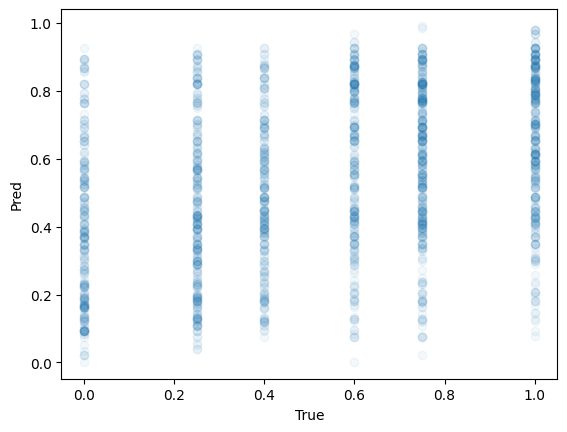

In [25]:
# plt.scatter(historyElo, predictionsElo, alpha=0.05)
plt.scatter(historyMElo, predictionsMElo, alpha=0.05)
# plt.scatter(historyenMElo, predictionsenMElo, alpha=0.05)
plt.xlabel("True")
plt.ylabel("Pred")

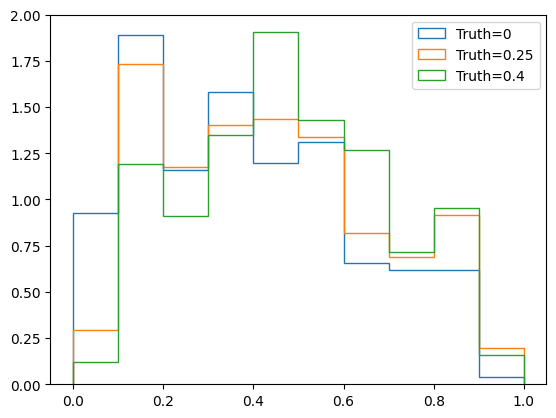

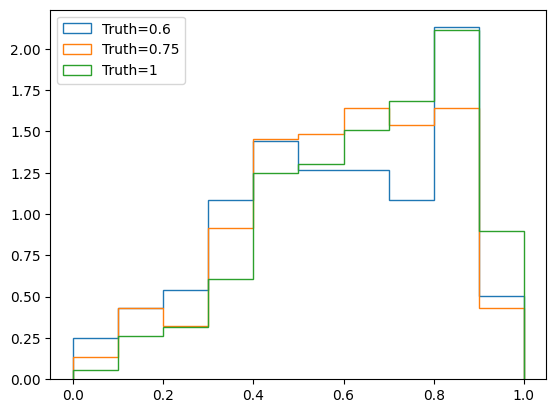

In [26]:
bins_=10
history_p = [0, 0.25, 0.4, 0.6, 0.75, 1]
for p in history_p[:3]:
    plt.hist(predictionsMElo[historyMElo == p], range=[0, 1], bins=bins_, histtype='step', density=True, label=f"Truth={p}");

plt.legend();
plt.show()

for p in history_p[3:]:
    plt.hist(predictionsMElo[historyMElo == p], range=[0, 1], bins=bins_, histtype='step', density=True, label=f"Truth={p}");

plt.legend();
plt.show()

# Inference

In [33]:
player1 = 'Folwarski J.'
player2 = 'Brossier B.'

found_p1, found_p2, p_point = modelMElo_test.predict_point(player1, player2)
found_p1, found_p2, p_set = modelMElo_test.predict_set(player1, player2)
found_p1, found_p2, p_game = modelMElo_test.predict_game(player1, player2)

In [34]:
print(f"p({player1} wins a point)  = {p_point:.4f}")
print(f"p({player1} wins a set)    = {p_set:.4f}")
print(f"p({player1} wins the game) = {p_game:.4f}")

p(Folwarski J. wins a point)  = 0.5000
p(Folwarski J. wins a set)    = 0.5000
p(Folwarski J. wins the game) = 0.5000


In [35]:
found_p1, found_p2, ps_set = modelMElo_test.predict_set_config(player1, player2)

for points, p in ps_set.items():
    print(f"p({player1} wins a set with total points={points}) = {p:.4f}")

p(Folwarski J. wins a set with total points=11) = 0.0005
p(Folwarski J. wins a set with total points=12) = 0.0027
p(Folwarski J. wins a set with total points=13) = 0.0081
p(Folwarski J. wins a set with total points=14) = 0.0175
p(Folwarski J. wins a set with total points=15) = 0.0305
p(Folwarski J. wins a set with total points=16) = 0.0458
p(Folwarski J. wins a set with total points=17) = 0.0611
p(Folwarski J. wins a set with total points=18) = 0.0742
p(Folwarski J. wins a set with total points=19) = 0.0835
p(Folwarski J. wins a set with total points=20) = 0.0881
p(Folwarski J. wins a set with total points=22) = 0.0881


In [ ]:
# by defalt, who wins 3 sets will win the game
found_p1, found_p2, ps_game = modelMElo_test.predict_game_config(player1, player2)

for points, p in ps_game.items():
    print(f"p({player1} wins the game with total sets={points}) = {p:.4f}")

p(Folwarski J. wins the game with total sets=3) = 0.2401
p(Folwarski J. wins the game with total sets=4) = 0.2726
p(Folwarski J. wins the game with total sets=5) = 0.2063


In [ ]:
# if the rule of the game is: who wins 5 sets will win the game
n_win_sets = 5
found_p1, found_p2, ps_game = modelMElo_test.predict_game_config(player1, player2, n_win_sets)

for points, p in ps_game.items():
    print(f"p({player1} wins the game with total sets={points}) = {p:.4f}")

p(Folwarski J. wins the game with total sets=5) = 0.0928
p(Folwarski J. wins the game with total sets=6) = 0.1755
p(Folwarski J. wins the game with total sets=7) = 0.1993
p(Folwarski J. wins the game with total sets=8) = 0.1760
p(Folwarski J. wins the game with total sets=9) = 0.1332


In [36]:
# traditional Elo
modelMElo_all = ModifiedElo()

# traing model with only training set
modelMElo_all.fit(X_all)


Training model: 100%|██████████| 34579/34579 [00:01<00:00, 18044.89it/s]


In [ ]:
player1 = 'Nalepa K.'
player2 = 'Tymofeev O.'
o1 = 4.
o2 = 1.22

found_p1, found_p2, p_game = modelMElo_all.predict_game(player1, player2)
if (found_p1 and found_p2):
    print(p_game, 1-p_game, p_game*o1, (1-p_game)*o2)

0.4263657401346591 0.5736342598653409 1.7054629605386364 0.6998337970357159


In [ ]:
f"{player1} v {player2} -    {player1 if p_game>0.5 else player2}"


# Jan 24, 8:35 - Hordynska-Sheiko A. v Ivchenko O. -    Ivchenko O.    (Ivchenko O. 1.011)
# Jan 24: 9:35 - Severina Y. v Gordeets M. -    Gordeets M.    (Severina Y. 1.04)
# Jan 24: 10:35 - Gordeets M. v Ivchenko O. -    Ivchenko O.
# Jan 24: 11:05 - Lifanova O. v Severina Y. -    Lifanova O.    (Severina Y. 1.14)
# Jan 24: 11:35 - Hordynska-Sheiko A. v Gordeets M. -    Gordeets M.
# Jan 24: 12:35 - Lifanova O. v Ivchenko O. -    Ivchenko O.    (Ivchenko O. 1.097)
# Jan 24: 13:05 - Hordynska-Sheiko A. v Severina Y. -    Severina Y.
# Jan 24: 13:35 - Lifanova O. v Gordeets M. -    Lifanova O.
# Jan 24: 14:35 - Hordynska-Sheiko A. v Lifanova O. -    Lifanova O.    (Hordynska-Sheiko A. 1.248)
# Jan 24: 15:05 - Severina Y. v Ivchenko O. -    Ivchenko O.    (Ivchenko O. 1.063)


'Nalepa K. v Tymofeev O. -    Tymofeev O.'

In [ ]:
p1_name = 'Lif'

for k, v in modelMElo_all.params.items():
    if p1_name in k:
        print(k, v)
        break

## Plots

In [27]:
df_data = pd.DataFrame([historyMElo, predictionsMElo]).T

df_data.columns = ['g', 'x']
df_data = df_data[df_data.g != 1/3]

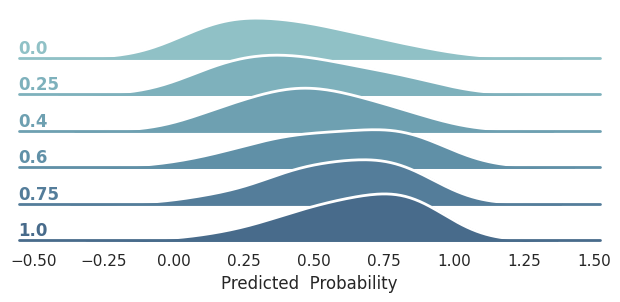

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_data, row="g", hue="g", aspect=15, height=.5, palette=pal)

bw_adjust = 2
# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=bw_adjust, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=bw_adjust)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# g.set(xlim=(0, 1))

# Set the x-axis label
g.set(xlabel="Predicted  Probability")  # Change the x-axis label here

In [29]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

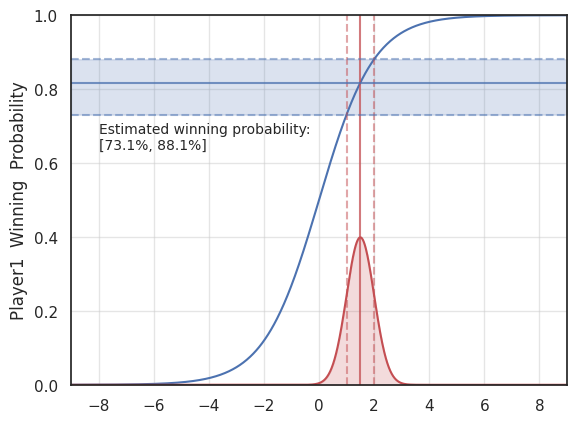

In [30]:

from scipy.stats import norm

x = np.linspace(-9, 9, 1000)
plt.plot(x, sigmoid(x))

mu = 1.5
sigma = 0.5
y = norm.pdf(x, mu, sigma)  # Probability density function

# Plot the Gaussian distribution on top of the existing plot
y_plot = y*0.5
line, = plt.plot(x, y_plot, 'r-', label='Gaussian Distribution')
plt.fill_between(x, y_plot, color=line.get_color(), alpha=0.2)



plt.axvline(x=mu, color='r', linestyle='-', alpha=0.75)
plt.axvline(x=mu+sigma, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=mu-sigma, color='r', linestyle='--', alpha=0.5)

# Plot the corresponding horizontal line
plt.axhline(y=sigmoid(mu), color='b', linestyle='-', alpha=0.75)
plt.axhline(y=sigmoid(mu+sigma), color='b', linestyle='--', alpha=0.5)
plt.axhline(y=sigmoid(mu-sigma), color='b', linestyle='--', alpha=0.5)

plt.fill_between(x, sigmoid(mu-sigma), sigmoid(mu+sigma), color='b', alpha=0.2)

plt.ylim(0, 1.)

plt.text(-8, .67, f"Estimated winning probability: \n[{sigmoid(mu-sigma)*100:.1f}%, {sigmoid(mu+sigma)*100:.1f}%]", fontsize=10,
        ha="left", va="center")

# Add gridlines
plt.grid(True, linestyle='-', alpha=0.5)

plt.ylabel("Player1  Winning  Probability");

plt.margins(x=0)

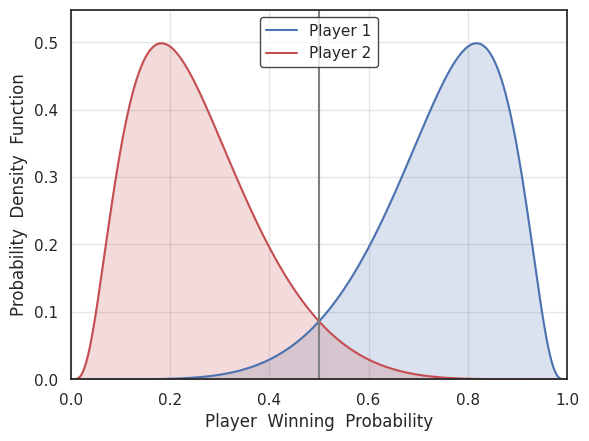

In [91]:

from scipy.stats import norm

x = np.linspace(-9, 9, 1000)
# plt.plot(x, sigmoid(x))

mu = 1.5
sigma = 0.8
y = sigmoid(norm.pdf(x, mu, sigma))  # Probability density function
y = norm.pdf(x, mu, sigma)  # Probability density function
z = sigmoid(x)

# Plot the Gaussian distribution on top of the existing plot
y_plot = y
# y_plot = y_plot - min(y_plot)
# line, = plt.plot(x, y_plot, 'r-', label='Gaussian Distribution')
line, = plt.plot(z, y_plot, 'b-', label='Player 1')
plt.fill_between(z, y_plot, color=line.get_color(), alpha=0.2)
line, = plt.plot(1-z, y_plot, 'r-', label='Player 2')
plt.fill_between(1-z, y_plot, color=line.get_color(), alpha=0.2)
# plt.fill_between(x, y_plot, color=line.get_color(), alpha=0.2)


plt.axvline(0.5, color='grey')
# Add gridlines
plt.grid(True, linestyle='-', alpha=0.5)
# plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, max(y_plot)*1.1)
plt.ylabel("Probability  Density  Function");
plt.xlabel("Player  Winning  Probability");
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')

plt.margins(x=0)

260.85793997548

In [123]:
modelMElo_all.params
player1 = 'Lifanova O.'
player2 = 'Volgina A.'

In [124]:
found_p1, found_p2, ps_set1 = modelMElo_all.predict_set_config(player1, player2)
found_p1, found_p2, ps_set2 = modelMElo_all.predict_set_config(player2, player1)

In [125]:
ps_set = {}
for k, v in ps_set1.items():
    kk = str(k)
    if k == 22: kk = ">" + str(k-1)
    ps_set[kk] = v + ps_set2[k]



In [126]:
ps_set1_ = {}
for k, v in ps_set1.items():
    kk = str(k)
    if k == 22: kk = ">" + str(k-1)
    ps_set1_[kk] = v

ps_set2_ = {}
for k, v in ps_set2.items():
    kk = str(k)
    if k == 22: kk = ">" + str(k-1)
    ps_set2_[kk] = v



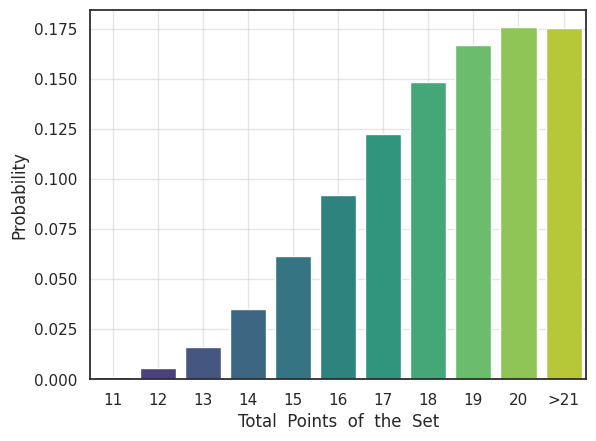

In [127]:
keys = list(ps_set.keys())
values = list(ps_set.values())

# Create a barplot using seaborn
sns.barplot(x=keys, y=values, palette='viridis');

plt.xlabel("Total  Points  of  the  Set")
plt.ylabel("Probability")
plt.grid(True, linestyle='-', alpha=0.5)

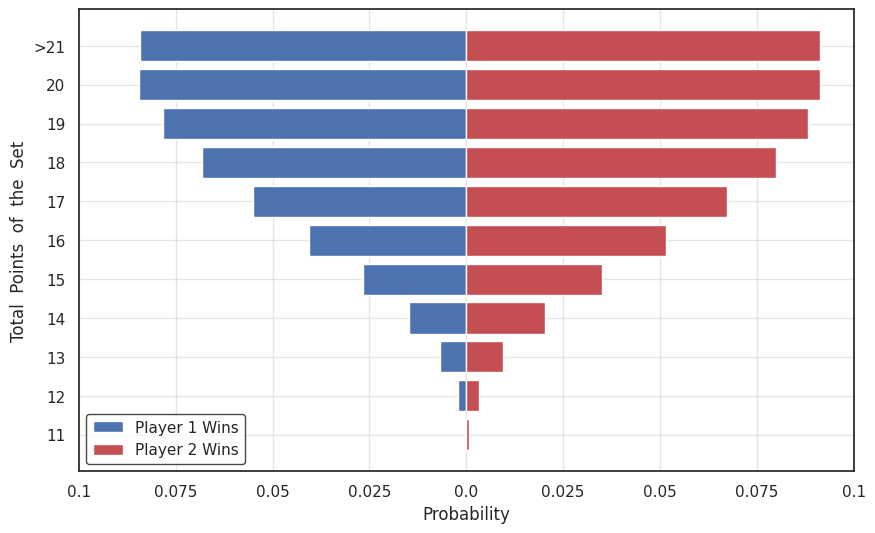

In [128]:

# Convert dictionaries to lists
keys1 = list(ps_set2_.keys())
values1 = list(ps_set2_.values())

keys2 = list(ps_set1_.keys())
values2 = list(ps_set1_.values())

# Create the figure
plt.figure(figsize=(10, 6))

# Define colors for each dict
color1 = 'b'  # Color for dict1 (left)
color2 = 'r'  # Color for dict2 (right)

# Plot the first dictionary on the left (negative values)
for i, (key, value) in enumerate(zip(keys1, values1)):
    plt.barh(key, -value, color=color1, label='Player 1 Wins' if i == 0 else "")  # Negative for left side

# Plot the second dictionary on the right (positive values)
for i, (key, value) in enumerate(zip(keys2, values2)):
    plt.barh(key, value, color=color2, label='Player 2 Wins' if i == 0 else "")  # Positive for right side

# Customize the plot
plt.xlabel('Probability')
plt.ylabel('Total  Points  of  the  Set')
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')

plt.xlim(-0.1, 0.1)

xticks = plt.gca().get_xticks()  # Get the current x-axis ticks
plt.xticks(xticks, [abs(round(tick,4)) for tick in xticks])  # Change ticks to absolute values

plt.grid(True, linestyle='-', alpha=0.5)
# Display the plot
plt.show()


<Figure size 1000x600 with 0 Axes>

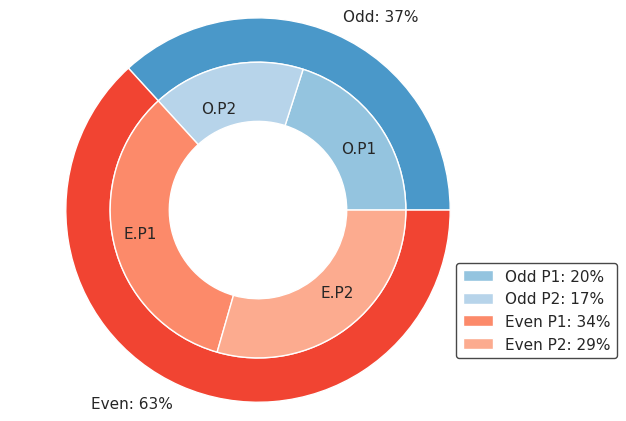

In [186]:

# Convert dictionaries to lists
keys1 = list(ps_set2_.keys())
values1 = list(ps_set2_.values())

keys2 = list(ps_set1_.keys())
values2 = list(ps_set1_.values())

# Create the figure
plt.figure(figsize=(10, 6))

# Define colors for each dict
color1 = 'b'  # Color for dict1 (left)
color2 = 'r'  # Color for dict2 (right)

odd1 = 0
even1 = 0
odd2 = 0
even2 = 0
for k in keys1:
    if k[0] == '>':
        even1 += ps_set1_[k]
    elif float(k) % 2 == 0:
        even1 += ps_set1_[k]
    else:
        odd1 += ps_set1_[k]
for k in keys2:
    if k[0] == '>':
        even2 += ps_set2_[k]
    elif float(k) % 2 == 0:
        even2 += ps_set2_[k]
    else:
        odd2 += ps_set2_[k]



group_size = [odd1+odd2, even1+even2]
group_names = [f'Odd: {((odd1+odd2)*100):.0f}%', f'Even: {((even1+even2)*100):.0f}%']
subgroup_size = [odd1, odd2, even1, even2]
subgroup_names = [f'O.P1', 'O.P2', 'E.P1', 'E.P2']
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
a, b=[plt.cm.Blues, plt.cm.Reds]
# a, b=['b', 'r']
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=
[a(0.6), b(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')

# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3,
labels=subgroup_names, labeldistance=0.7, colors=[a(0.4), a(0.3), b(0.4), b(0.3)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

plt.legend(loc=(0.9, 0.1))
handles, labels = ax.get_legend_handles_labels()
subgroup_names_legs = [f'Odd P1: {((odd1)*100):.0f}%', f'Odd P2: {((odd2)*100):.0f}%',
                       f'Even P1: {((even1)*100):.0f}%', f'Even P2: {((even2)*100):.0f}%']

legend = ax.legend(handles[2:], subgroup_names_legs, loc=(0.9, 0.1))
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')
plt.show()


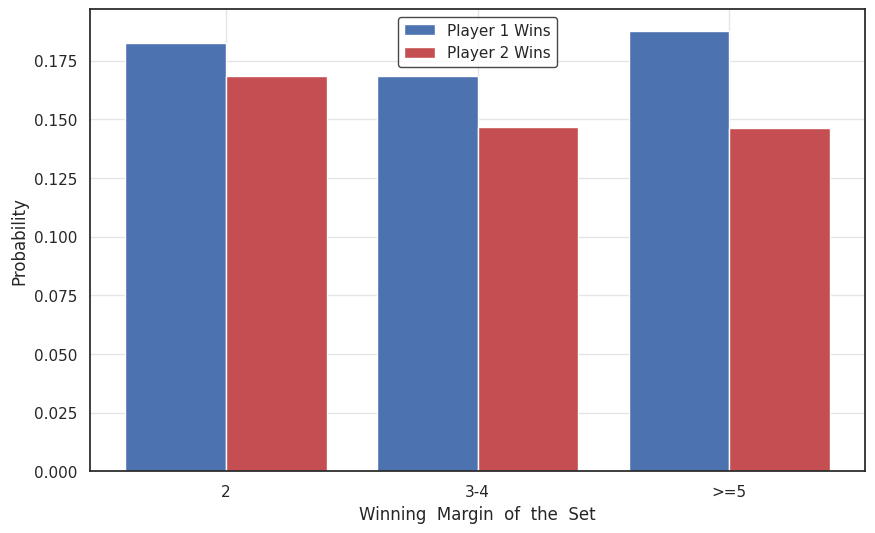

In [224]:

# Convert dictionaries to lists
keys1 = list(ps_set2_.keys())
values1 = list(ps_set2_.values())

keys2 = list(ps_set1_.keys())
values2 = list(ps_set1_.values())

# Create the figure
plt.figure(figsize=(10, 6))

# Define colors for each dict
color1 = 'b'  # Color for dict1 (left)
color2 = 'r'  # Color for dict2 (right)

def find_margin(ps_set1_):
    keys1 = list(ps_set1_.keys())
    values1 = list(ps_set1_.values())
    margin1 = {"2": 0, "3-4": 0, ">=5": 0}
    for i, (key, value) in enumerate(zip(keys1, values1)):
        if key[0] == '>':
            # print("2")
            margin1["2"] += value
        elif (22-float(key)) == 2:
            # print("2")
            margin1["2"] += value
        elif (22-float(key)) >= 5:
            # print(">=5")
            margin1[">=5"] += value
        else:
            # print("3-4")
            margin1["3-4"] += value
    return margin1


margin1 = find_margin(ps_set1_)
margin2 = find_margin(ps_set2_)



# Plot the first dictionary on the left (negative values)
for i, (key, value) in enumerate(margin1.items()):
    # plt.bar(key, -value, color=color1, label='Player 1 Wins' if i == 0 else "", height=0.75)  # Negative for left side
    plt.bar(i-0.2, value, color=color1, label='Player 1 Wins' if i == 0 else "", width=0.4)  # Negative for left side

# Plot the second dictionary on the right (positive values)
for i, (key, value) in enumerate(margin2.items()):
    plt.bar(i+0.2, value, color=color2, label='Player 2 Wins' if i == 0 else "", width=0.4)  # Positive for right side

# Customize the plot
plt.ylabel('Probability')
plt.xlabel('Winning  Margin  of  the  Set')
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')

# plt.xlim(0.5, 3.5)

xticks = plt.gca().get_xticks()  # Get the current x-axis ticks
# plt.xticks(xticks, [abs(round(tick,4)) for tick in xticks])  # Change ticks to absolute values
plt.xticks([r for r in range(len(margin1))],
        list(margin1.keys()))

plt.grid(True, linestyle='-', alpha=0.5)
# Display the plot
plt.show()
